# Importing Libraries


In [6]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.finance_ml.data_preparation.data_preparation import DataLoader


# --- Data Initialization and Data Loading ---

In [7]:
# Load the data
dataloader = DataLoader(time_index_col= 'DATE', 
                    keep_cols = ['VOLUME','OPEN', 'CLOSE', 'LOW', 'TRANSACTIONS'])

# loading assets into to an unique df
df = dataloader.load_dataset({'GOLD':'../data/commodities/GLD_2020-04-07_2022-04-06.parquet',
                        'BITCOINS':'../data/cryptos/BTCUSD_2020-04-07_2022-04-06.parquet',
                        'SRET':'../data/real_estate/SRET_2020-04-07_2022-04-06.parquet'})

df.head(10)

,GOLD_VOLUME,GOLD_OPEN,GOLD_CLOSE,GOLD_LOW,GOLD_TRANSACTIONS,BITCOINS_VOLUME,BITCOINS_OPEN,BITCOINS_CLOSE,BITCOINS_LOW,BITCOINS_TRANSACTIONS,SRET_VOLUME,SRET_OPEN,SRET_CLOSE,SRET_LOW,SRET_TRANSACTIONS
DATE,,,,,,,,,,,,,,,
2020-04-07 15:43:00,21071.0,155.880,155.926,155.860,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07 15:44:00,23010.0,155.930,155.900,155.900,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07 15:45:00,31544.0,155.920,155.735,155.720,292.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07 15:46:00,42645.0,155.760,155.840,155.760,153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07 15:47:00,3735.0,155.805,155.810,155.795,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07 15:48:00,10175.0,155.820,155.800,155.800,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07 15:49:00,18026.0,155.790,155.780,155.770,161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07 15:50:00,13651.0,155.780,155.720,155.670,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07 15:51:00,4551.0,155.710,155.690,155.670,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# --- Data Processing and Feature Calculation ---

In [8]:
assets_close = ["BITCOINS_CLOSE","GOLD_CLOSE","SRET_CLOSE"]

# Loop through Each Asset(Closing Price) to Calculate Features
for close in assets_close:
    # Calculate daily return for each asset
    df[f'Daily_Return_{close}'] = df[close].pct_change(fill_method=None).abs()
    df[f'Daily_Return_{close}'] = df[f'Daily_Return_{close}'].fillna(0)
  
    # Calculation of weight based on return for each asset
    df[f'weight_by_return_{close}'] = df[f'Daily_Return_{close}'] / df[f'Daily_Return_{close}'].max()

    # Calculation of Weights based on Recency (Time Decay) for each asset 
    # Access the latest date from the index for each asset
    latest_date = df.index.max()
    df[f'Days_From_Latest_{close}'] = (latest_date - df.index).days
    decay_rate = 0.01
    df[f'weight_by_time_decay_{close}'] = np.exp(-decay_rate * df[f'Days_From_Latest_{close}'])

# --- Initializing and Integrating Weight Columns into DataFrame ---

In [9]:
# Create a list of all weight columns for each asset
weight_columns = [f'weight_by_return_{close}' for close in assets_close] + \
                 [f'weight_by_time_decay_{close}' for close in assets_close]

#Creating and initializing weight columns
for column in weight_columns:
    if column not in df.columns:
        df[column] = 0 

# Reset DataFrame Index
df = df.reset_index(drop=True)

# Sampling weights
sampled_weights = df[weight_columns]

#Updating the original DataFrame with sampled values
for column in weight_columns:
    df.loc[sampled_weights.index, column] = sampled_weights[column]

df.head(10)

,GOLD_VOLUME,GOLD_OPEN,GOLD_CLOSE,GOLD_LOW,GOLD_TRANSACTIONS,BITCOINS_VOLUME,BITCOINS_OPEN,BITCOINS_CLOSE,BITCOINS_LOW,BITCOINS_TRANSACTIONS,...,Days_From_Latest_BITCOINS_CLOSE,weight_by_time_decay_BITCOINS_CLOSE,Daily_Return_GOLD_CLOSE,weight_by_return_GOLD_CLOSE,Days_From_Latest_GOLD_CLOSE,weight_by_time_decay_GOLD_CLOSE,Daily_Return_SRET_CLOSE,weight_by_return_SRET_CLOSE,Days_From_Latest_SRET_CLOSE,weight_by_time_decay_SRET_CLOSE
0,21071.0,155.880,155.926,155.860,152.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000000,0.000000,729,0.000682,0.0,0.0,729,0.000682
1,23010.0,155.930,155.900,155.900,165.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000167,0.007738,729,0.000682,0.0,0.0,729,0.000682
2,31544.0,155.920,155.735,155.720,292.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.001058,0.049114,729,0.000682,0.0,0.0,729,0.000682
3,42645.0,155.760,155.840,155.760,153.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000674,0.031288,729,0.000682,0.0,0.0,729,0.000682
4,3735.0,155.805,155.810,155.795,47.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000193,0.008933,729,0.000682,0.0,0.0,729,0.000682
5,10175.0,155.820,155.800,155.800,89.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000064,0.002978,729,0.000682,0.0,0.0,729,0.000682
6,18026.0,155.790,155.780,155.770,161.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000128,0.005957,729,0.000682,0.0,0.0,729,0.000682
7,13651.0,155.780,155.720,155.670,118.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000385,0.017873,729,0.000682,0.0,0.0,729,0.000682
8,4551.0,155.710,155.690,155.670,55.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000193,0.008940,729,0.000682,0.0,0.0,729,0.000682
9,5125.0,155.700,155.630,155.610,96.0,NaN,NaN,NaN,NaN,NaN,...,729,0.000682,0.000385,0.017884,729,0.000682,0.0,0.0,729,0.000682


# --- Visulization ---

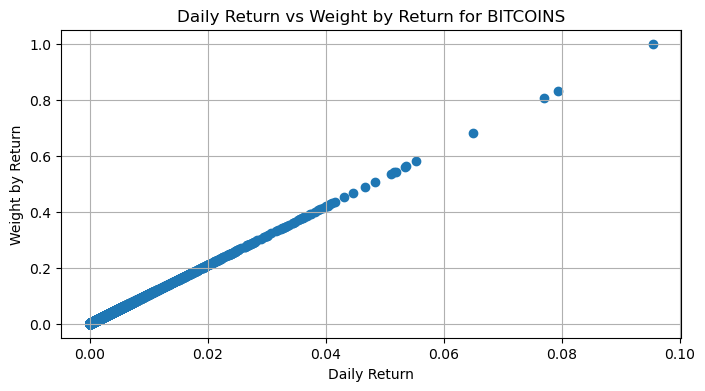

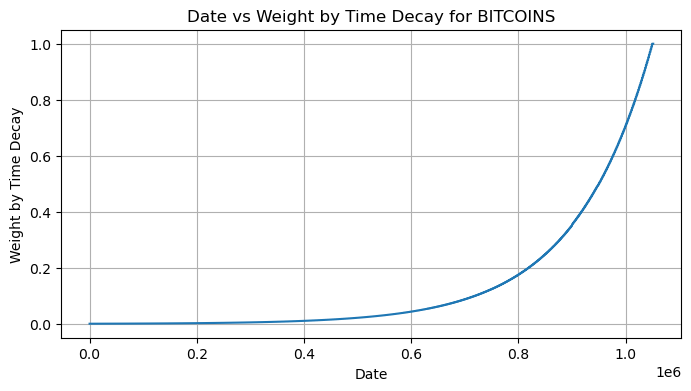

In [10]:
#Visulization of sampled weights for bitcoin

asset = 'BITCOINS'
#weights by return
plt.figure(figsize=(8, 4))
plt.scatter(df[f'Daily_Return_{asset}_CLOSE'], df[f'weight_by_return_{asset}_CLOSE'])
plt.title(f'Daily Return vs Weight by Return for {asset}')
plt.xlabel('Daily Return')
plt.ylabel('Weight by Return')
plt.grid(True)

#weights by time decay
plt.figure(figsize=(8, 4))
plt.plot(df.index, df[f'weight_by_time_decay_{asset}_CLOSE'])
plt.title(f'Date vs Weight by Time Decay for {asset}')
plt.xlabel('Date')
plt.ylabel('Weight by Time Decay')
plt.grid(True)
plt.show()
